In [2]:
import torch  
import torch.nn as nn  
import torch.optim as optim  
from torchvision import datasets, transforms  
from torch.utils.data import DataLoader  
import matplotlib.pyplot as plt  
import numpy as np  

In [3]:
# 提前规划数据处理模式
transform = transforms.Compose([
    transforms.ToTensor(),                      # 张量化
    transforms.Normalize((0.1307,), (0.3081,))  # 标准化
])

In [7]:
# 加载训练集
train_dataset = datasets.MNIST(
    root='C:\MNISTdataSets', 
    train=True,#这里声明是训练集
    download=True,  
    transform=transform
)

# 从训练集中拆分出验证集
train_dataset, val_dataset = torch.utils.data.random_split(
    train_dataset, [50000, 10000]
)

# 加载测试集
test_dataset = datasets.MNIST(
    root='C:\MNISTdataSets',
    train=False,#声明非训练集
    download=True,
    transform=transform
)

100.0%
100.0%
100.0%
100.0%


In [8]:
batch_size = 32  # 32个样本，小批量的训练，方便梯度下降

#这里我们用加载器从数据集里加载数据而不是直接加载全部数据
#因为一次性加载大量图片对内存的压力很大
#并且本身小批量训练做梯度下降每次也只用加载部分数据

# 训练集加载器
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True #这里我们要打乱顺序也就是防止总是按照 0123这种有序顺序，让模型学岔了
)

# 验证集加载器（不需要打乱因为模型不会学这个东西）
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)

# 测试集加载器（同验证集）
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

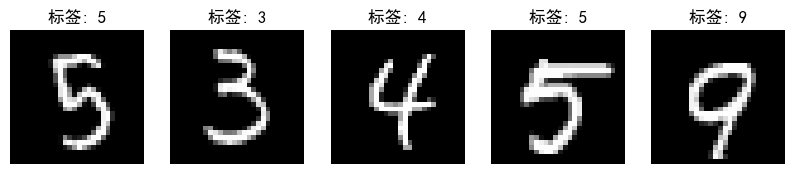

In [22]:
# 取一个批量的训练数据
images, labels = next(iter(train_loader))
plt.rcParams["font.family"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False
# 显示前 5 张图，验证数据集没问题加载器没问题
plt.figure(figsize=(10, 2))#创建画布
for i in range(5):
    plt.subplot(1, 5, i+1)
    img = images[i].squeeze().numpy()
    plt.imshow(img, cmap='gray')
    plt.title(f"标签: {labels[i].item()}")  # 显示真实标签
    plt.axis('off')
plt.show()#展示画布

In [13]:
class SoftmaxModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(784, 10)  # 线性层：z = wx + b（784→10）28x28 = 784个像素的图片，10代表0到9的数字，前者变量存储像素存在情况，后者存储概率                                                              
    
    def forward(self, x):
        # 前向传播：先把图像展平（[batch,1,28,28] → [batch,784]），再过线性层
        x = x.view(x.size(0), -1)  # 展平操作（-1 表示自动计算维度）
        z = self.linear(x)  # 输出原始分数（还没经过 Softmax）
        return z  # 注意：这里不手动算 Softmax，交给损失函数处理

In [14]:
model = SoftmaxModel()  # 创建 Softmax 模型实例

In [15]:
# 交叉熵损失 包含了 Softmax 操作 这里我们直接用它的函数 实际怎么算的我们在readme里面讨论和思考
criterion = nn.CrossEntropyLoss()

In [16]:
learning_rate = 0.1 
optimizer = optim.SGD(model.parameters(), lr=learning_rate)  

In [17]:
def train(model, train_loader, criterion, optimizer, epoch):
    model.train()  # 切换到训练模式（PyTorch 要求，用于 BatchNorm 等层）
    train_loss = 0.0  # 累计训练损失
    correct = 0  # 累计正确预测数
    total = 0  # 总样本数
    
    for batch_idx, (data, target) in enumerate(train_loader):
        # 前向传播：算预测值
        outputs = model(data)  # 输出原始分数（10 类）
        
        # 计算损失
        loss = criterion(outputs, target)
        train_loss += loss.item()  # 这里我们做累加，因为我们是分了批次来训练的模型
        
        # 反向传播 + 更新参数
        optimizer.zero_grad()  # 依旧记得清空梯度防止累加导致错误
        loss.backward()  # 自动算梯度
        optimizer.step()  # 更新参数（w 和 b）
        
        # 计算准确率（取概率最大的类别作为预测结果）
        _, predicted = torch.max(outputs.data, 1)  # 第二个返回值是预测类别 去掉最大概率的值
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
        # 每 100 个批量打印一次进度
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx*len(data)}/{len(train_loader.dataset)} '
                  f'({100.*batch_idx/len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    
    # 计算平均损失和准确率
    avg_loss = train_loss / len(train_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

#和测试集检测
def validate(model, val_loader, criterion):
    model.eval()  
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in val_loader:
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    avg_loss = val_loss / len(val_loader)
    accuracy = 100. * correct / total
    print(f'\nValidation set: Average loss: {avg_loss:.4f}, '
          f'Accuracy: {correct}/{total} ({accuracy:.2f}%)\n')
    return avg_loss, accuracy

In [18]:
num_epochs = 10  # 训练 10 轮

# 记录损失和准确率（用于画图）
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(1, num_epochs + 1):
    # 训练
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, epoch)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # 验证
    val_loss, val_acc = validate(model, val_loader, criterion)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.451811
Train Epoch: 1 [3200/50000 (6%)]	Loss: 0.579203
Train Epoch: 1 [6400/50000 (13%)]	Loss: 0.591381
Train Epoch: 1 [9600/50000 (19%)]	Loss: 0.950534
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.258407
Train Epoch: 1 [16000/50000 (32%)]	Loss: 0.648756
Train Epoch: 1 [19200/50000 (38%)]	Loss: 0.731604
Train Epoch: 1 [22400/50000 (45%)]	Loss: 0.221999
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.113987
Train Epoch: 1 [28800/50000 (58%)]	Loss: 0.363852
Train Epoch: 1 [32000/50000 (64%)]	Loss: 0.787599
Train Epoch: 1 [35200/50000 (70%)]	Loss: 0.428797
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.277160
Train Epoch: 1 [41600/50000 (83%)]	Loss: 0.451300
Train Epoch: 1 [44800/50000 (90%)]	Loss: 0.333659
Train Epoch: 1 [48000/50000 (96%)]	Loss: 0.677120

Validation set: Average loss: 0.4964, Accuracy: 8712/10000 (87.12%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.236079
Train Epoch: 2 [3200/50000 (6%)]	Loss: 0.392444
Train Epoch: 2 [6400/50000 (13%)]	Loss: 0.4190

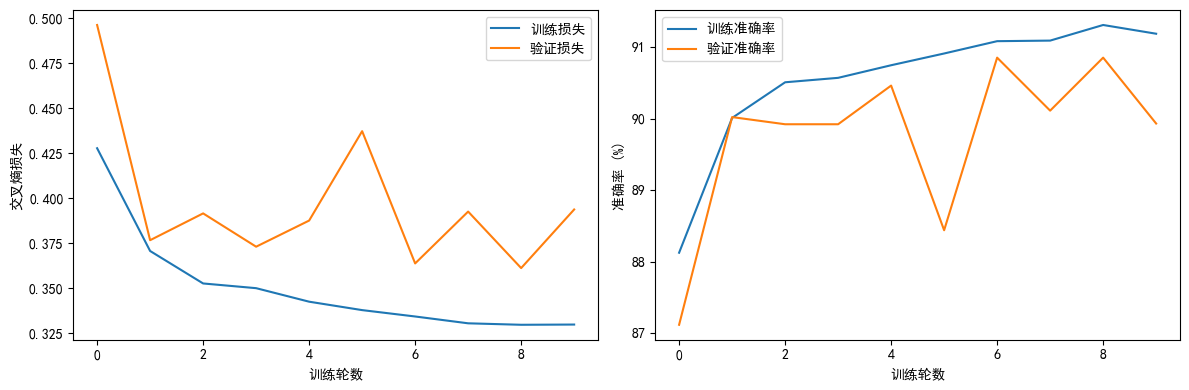

In [19]:
plt.figure(figsize=(12, 4))

# 损失曲线
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='训练损失')
plt.plot(val_losses, label='验证损失')
plt.xlabel('训练轮数')
plt.ylabel('交叉熵损失')
plt.legend()

# 准确率曲线
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='训练准确率')
plt.plot(val_accs, label='验证准确率')
plt.xlabel('训练轮数')
plt.ylabel('准确率 (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
def test(model, test_loader):
    model.eval()
    test_preds = []  # 保存测试集预测结果
    test_labels = []  # 保存测试集真实标签
    
    with torch.no_grad():
        for data, target in test_loader:
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            test_preds.extend(predicted.numpy())  # 转成 numpy 并存起来
            test_labels.extend(target.numpy())
    
    # 计算测试集准确率
    accuracy = 100. * np.sum(np.array(test_preds) == np.array(test_labels)) / len(test_labels)
    print(f'Test set accuracy: {accuracy:.2f}%')
    return test_preds

# 得到测试集预测结果
test_preds = test(model, test_loader)

Test set accuracy: 90.44%


In [21]:
import pandas as pd

# 生成提交 DataFrame（ImageId 从 1 开始，Label 是预测结果）
submission = pd.DataFrame({
    'ImageId': range(1, len(test_preds) + 1),
    'Label': test_preds
})

# 保存为 CSV 文件
submission.to_csv('mnist_softmax_submission.csv', index=False)
print("提交文件已生成：mnist_softmax_submission.csv")

提交文件已生成：mnist_softmax_submission.csv
